In [2]:
"""
将结果绘制成曲线图
"""
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import heapq
import random
import os
from scipy.io import loadmat


# 读取数据
def get_data(city):
    with open('data_proces/' + city + 'data_heterHyper.pickle', 'rb') as file:
        data_social = pickle.load(file)

    friendship_new_df = data_social['friendship_new_df']
    friendship_old_df = data_social['friendship_old_df']
    deepwalk_S_id_vec_list = data_social['deepwalk_S_id_vec_list']
    num_u = len(deepwalk_S_id_vec_list) - 1

    # 为了方便GAT训练，这里把用户的id都-1，让id从0开始
    for ii in range(len(friendship_old_df)):
        friendship_old_df['uid1'][ii] -= 1
        friendship_old_df['uid2'][ii] -= 1
    for ii in range(len(friendship_new_df)):
        friendship_new_df['uid1'][ii] -= 1
        friendship_new_df['uid2'][ii] -= 1

    return friendship_new_df, friendship_old_df, num_u


# 计算LBSN时专用
def get_mat_dataset_friends(city):
    sources_directory = '/workspace/dataset/Foursquare/sources'
    city_mat_fp = os.path.join(sources_directory, 'dataset_connected_{city}.mat')
    mat_fp = city_mat_fp.format(city=city)
    mat_dict = loadmat(mat_fp)
    friendship_new_np = mat_dict['friendship_new']
    friendship_old_np = mat_dict['friendship_old']
    friendship_new_df = pd.DataFrame(friendship_new_np, columns=['uid1', 'uid2'])
    friendship_old_df = pd.DataFrame(friendship_old_np, columns=['uid1', 'uid2'])
    num_u = max(max(friendship_new_df['uid1']), max(friendship_new_df['uid2']), max(friendship_old_df['uid1']),
                max(friendship_old_df['uid2']))

    for ii in range(len(friendship_old_df)):
        friendship_old_df['uid1'][ii] -= 1
        friendship_old_df['uid2'][ii] -= 1
    for ii in range(len(friendship_new_df)):
        friendship_new_df['uid1'][ii] -= 1
        friendship_new_df['uid2'][ii] -= 1

    return friendship_new_df, friendship_old_df, num_u


# 读取LBSN2Vec的数据
def get_mat_dataset(emb_path, city):
    # 读LBSN2VEC
    city_mat_fp = os.path.join(emb_path + 'embs_{city}.mat')
    mat_fp = city_mat_fp.format(city=city)
    mat_dict = loadmat(mat_fp)
    embs_usr = mat_dict['embs_user']

    prob_adj = cosinematrix(torch.tensor(embs_usr))
    for ii in range(len(prob_adj)):
        prob_adj[ii][ii] = 0

    return prob_adj


# 计算余弦相似度
def cosinematrix(A):
    prod = torch.mm(A, A.t())  # 分子
    norm = torch.norm(A, p=2, dim=1).unsqueeze(0)  # 分母
    cos = prod.div(torch.mm(norm.t(), norm))
    return cos


# 计算count_o2n_Acc_Recall中需要的link_new_labels_M，目的是为了保证计算各方法的结果时负采样一致
def count_link_lables(num_user, friendship_new_df, friendship_old_df, neg_num):
    # 社交网络邻接矩阵 考虑id从1开始
    link_new_labels_M = np.zeros((num_user, num_user))
    for uid1, uid2 in zip(friendship_new_df['uid1'], friendship_new_df['uid2']):
        link_new_labels_M[uid1][uid2] = 1
        link_new_labels_M[uid2][uid1] = 1
    # 旧社交网络邻接矩阵
    for uid1, uid2 in zip(friendship_old_df['uid1'], friendship_old_df['uid2']):
        link_new_labels_M[uid1][uid2] = 2  # 原new的社交链接中实际上是old+新增的社交链接，所以这里将新增社交链接中的旧链接去掉，防止影响后面预测（特别是召回率分母）
        link_new_labels_M[uid2][uid1] = 2
    if neg_num == 0:
        return link_new_labels_M
    # 进行负采样，只让采样上的为3，其他为0
    for link_u_new_l in link_new_labels_M:
        tensor_link_u_new_l = torch.tensor(link_u_new_l)
        pre_ind = torch.eq(tensor_link_u_new_l, 0).nonzero().numpy().tolist()
        for preI in random.sample(pre_ind, neg_num):  # 负样本随机抽取neg_num(50)个
            link_u_new_l[preI[0]] = 3
    return link_new_labels_M


# 提前计算好prob_adj每行排序后得到的index
def count_rank_prob_adj(prob_adj, link_new_labels_M, neg_num):
    prob_adj = prob_adj.cpu().detach().numpy()

    rank_index_prod = []
    for link_u_p, link_u_new_l in zip(prob_adj, link_new_labels_M):
        link_u_l = list(link_u_new_l)
        num_1 = link_u_l.count(1)  # 计算一下该用户应该有的链接数
        if num_1 == 0:  # 该用户没有新的社交链接 则跳过 不排序
            rank_index_prod.append([])
            continue
        if neg_num != 0:  # 要抽负样本
            tensor_link_u_new_l = torch.tensor(link_u_new_l)
            pre_ind = torch.eq(tensor_link_u_new_l, 1).nonzero().numpy().tolist()
            for preI in pre_ind:
                link_u_p[preI[0]] += 1000  # 正样本全参与预测
            pre_ind = torch.eq(tensor_link_u_new_l, 3).nonzero().numpy().tolist()
            for preI in pre_ind:
                link_u_p[preI[0]] += 1000  # 抽取的负样本参与预测
        sort_enu = sorted(enumerate(link_u_p), key=lambda line: line[1], reverse=True)
        sort_index = [x[0] for x in sort_enu]  # 得到从大到小排序后的坐标
        rank_index_prod.append(sort_index)

    return rank_index_prod


# 计算accuracy，recall计算,考虑旧的社交链接问题
def count_o2n_Acc_Recall(K_list, rank_index_prod, link_new_labels_M):
    len_K_list = len(K_list)
    P_K_list = [[] for _ in range(len_K_list)]
    R_K_list = [[] for _ in range(len_K_list)]
    # 计算精确度和召回率

    # 在全局中进行预测
    for line_rank, link_u_new_l in zip(rank_index_prod, link_new_labels_M):
        link_u_l = list(link_u_new_l)
        num_1 = link_u_l.count(1)  # 计算一下该用户应该有的链接数
        if num_1 == 0:  # 该用户没有新的社交链接 则跳过
            continue

        tmpK = 0
        N_u_true = 0
        index_K = 0
        for index in line_rank:
            if link_u_new_l[index] == 2:  # 旧的社交链接不参与预测
                continue
            if link_u_new_l[index] == 1:
                N_u_true += 1
            tmpK += 1
            if tmpK == K_list[index_K]:
                P_K_list[index_K].append(N_u_true / K_list[index_K])
                R_K_list[index_K].append(N_u_true / num_1)
                index_K += 1
                if index_K == len(K_list):
                    break
    P_list = []
    R_list = []
    F1_list = []
    for ii in range(len_K_list):
        P_ = sum(P_K_list[ii]) / len(P_K_list[ii])
        R_ = sum(R_K_list[ii]) / len(R_K_list[ii])
        if P_ + R_ != 0:
            F1_ = 2 * (P_ * R_) / (P_ + R_)
        else:
            F1_ = 0
        P_list.append(P_)
        R_list.append(R_)
        F1_list.append(F1_)

    return P_list, R_list, F1_list


# 链接预测
def linkPrediction(neg_num, K_list, cities):
    # 计算所有的曲线数值
    result_city_PRF1_method_neg = {}
    method_list = "tmp"
    for city in cities:
        # 读取数据
        # 读取各种方法的prob_adj
        with open('data_proces/' + city + '_prob_adj.pickle', 'rb') as file:
            prob_adj_city = pickle.load(file)
        # 再读LBSN2Vec
        emb_path = "../LBSN2vec/result_embs_60epoch_10neg_10win_0001rate/"
        prob_adj = get_mat_dataset(emb_path, city)
        prob_adj_city['LBSN2Vec'] = prob_adj

        method_list = prob_adj_city.keys()
        # 开始计算
        result_city_PRF1_method_neg[city] = {'P@K': {}, 'R@K': {}, 'F1@K': {}}
        print("*" * 20, "开始处理" + city + "的数据", "*" * 20)
        # 读取数据
        friendship_new_df, friendship_old_df, num_u = get_data(city)
        link_new_labels_M = count_link_lables(num_u, friendship_new_df, friendship_old_df, neg_num)

        for method in method_list:
            if method == 'LBSN2Vec':
                friendship_new_df, friendship_old_df, num_u = get_mat_dataset_friends(city)
                link_new_labels_M = count_link_lables(num_u, friendship_new_df, friendship_old_df, neg_num)
            print("-" * 10, "计算" + city + " " + method + " " + "-" * 10)
            rank_index_prod = count_rank_prob_adj(prob_adj_city[method], link_new_labels_M, neg_num)
            result_city_PRF1_method_neg[city]['P@K'][method] = []
            result_city_PRF1_method_neg[city]['R@K'][method] = []
            result_city_PRF1_method_neg[city]['F1@K'][method] = []

            P_list, R_list, F1_list = count_o2n_Acc_Recall(K_list, rank_index_prod, link_new_labels_M)
            for i_k in range(len(K_list)):
                result_city_PRF1_method_neg[city]['P@K'][method].append(P_list[i_k])
                result_city_PRF1_method_neg[city]['R@K'][method].append(R_list[i_k])
                result_city_PRF1_method_neg[city]['F1@K'][method].append(F1_list[i_k])
    return method_list, result_city_PRF1_method_neg

In [ ]:
# ssh://root@202.117.43.15:11100/root/miniconda3/envs/pyenv/bin/python -u /workspace/CurLink/parameter_sensitivity_stuy.py
# 阿尔法敏感性实验:
# P_liat: [[0.20283789473684494, 0.20720421052631868, 0.2050021052631609, 0.20600842105263445, 0.2063115789473715, 0.2066863157894765, 0.20706105263158178, 0.20437052631579217, 0.19808842105263386, 0.19552421052631824, 0.1830905263157916], [0.2608800000000037, 0.2657320000000037, 0.2706160000000038, 0.2688560000000041, 0.2693680000000038, 0.27233600000000385, 0.27142400000000383, 0.27222000000000407, 0.2736680000000039, 0.27318800000000415, 0.2543240000000038]]
# R_liat: [[0.5938346153608125, 0.613696268090728, 0.6072303281865177, 0.606744469317598, 0.607633966420826, 0.6069690670944151, 0.6099631013018894, 0.5972078104075369, 0.5772663400157491, 0.5726122631450854, 0.5362841419292019], [0.5731463424891273, 0.591149069996801, 0.603976603295558, 0.6010234309014033, 0.6066998349910293, 0.6119937574751223, 0.6032296769204751, 0.6120590216568311, 0.6230677471723145, 0.6145712292803449, 0.5606413686273592]]
# F1_liat: [[0.3023875510269728, 0.3098067073719299, 0.3065212548709292, 0.30758199099167904, 0.3080342489385041, 0.30836675853698814, 0.30916925274592766, 0.3045277639710956, 0.2949605244326101, 0.29150902645648935, 0.27298242964219344], [0.3585547607994922, 0.36664818869079924, 0.3737638601763097, 0.3715194210974534, 0.37308817941833566, 0.3769356747509448, 0.37438991289904394, 0.3768370336606305, 0.3802983119412531, 0.37824029549989496, 0.34991449124757257]]
# SHJ-walk的vec维度敏感性实验:
# P_liat: [[0.20026105263158156, 0.20609263157895027, 0.20797894736842407, 0.20939789473684506, 0.2072631578947397, 0.20609263157895058, 0.2036042105263185, 0.20652631578947683, 0.20202947368421342, 0.20392842105263448, 0.20370105263158167], [0.25452400000000347, 0.26537600000000383, 0.2704520000000038, 0.27123600000000375, 0.26755200000000356, 0.27131200000000383, 0.26806800000000386, 0.26909600000000405, 0.2694160000000038, 0.268784000000004, 0.26417200000000357]]
# R_liat: [[0.596981752972024, 0.6074416640327868, 0.6120399220035821, 0.6156686401333945, 0.6083660754666806, 0.60686960631581, 0.5970490042040165, 0.6104320247692099, 0.5890594405819325, 0.6005898007839623, 0.5979745494456685], [0.565375392331845, 0.5967451658405453, 0.604085471681443, 0.6069519076887229, 0.5951442868946593, 0.607065845210828, 0.5990109862705806, 0.5980627899870734, 0.6030588052870202, 0.5961351365293641, 0.5776122853001605]]
# F1_liat: [[0.29991394925416676, 0.3077658078431795, 0.310459247167302, 0.312507145394301, 0.30918849189393655, 0.3076923734312712, 0.30365541365590215, 0.308632963288452, 0.3008692546991677, 0.30447351372672515, 0.30388289286725995], [0.3510221546983597, 0.36737681868772387, 0.373627779161079, 0.3749231267917868, 0.3691485642704353, 0.37501822052885964, 0.3703822720986024, 0.37118030773538196, 0.37244272505090076, 0.3705110117340181, 0.3625362691543104]]
# ******************** GAT进行敏感性实验时只需要游走一次 ********************
# ******************** 计算：NYC ********************
# HMT-GAT的vec维度敏感性实验:
# P_list: [0.1694105263157915, 0.17539789473684414, 0.17680421052631787, 0.1816168421052654, 0.18054315789473904, 0.18693052631579168, 0.18013052631579168, 0.18579789473684452, 0.18781052631579195, 0.18614736842105492, 0.19215157894737078]
# R_list: [0.49857589850594286, 0.5125627052171027, 0.5151901205786921, 0.5326652932049024, 0.5329763944822896, 0.549396930463972, 0.5304950272989422, 0.548526162162694, 0.551458158052164, 0.5502187244044073, 0.5675954290065188]
# F1_list: [0.2528910106169832, 0.2613580429161316, 0.26326109245213625, 0.2708759913359454, 0.2697194049696914, 0.2789491216886436, 0.2689407126377914, 0.2775741769169505, 0.2801941741732868, 0.2781809845548835, 0.287106707425006]
# 注意力头敏感性实验:
# P_liat: [0.18186526315789672, 0.18137263157894928, 0.17801263157894948, 0.18330105263158097, 0.17978526315789672, 0.17972210526316007, 0.18789894736842344, 0.17957473684210748]
# R_liat: [0.5305734727072399, 0.5318358959739944, 0.5205929857712945, 0.5366880008155557, 0.5291540951959824, 0.5259532590092509, 0.5511943521965053, 0.528872625611937]
# F1_liat: [0.2708791323118188, 0.2704964125530349, 0.26530447695400566, 0.2732689687435331, 0.2683836199400767, 0.26789945536007764, 0.28025850725218526, 0.2681129457416978]
# ******************** 计算：SaoPaulo ********************
# HMT-GAT的vec维度敏感性实验:
# P_list: [0.18984421052631806, 0.1977094736842132, 0.20254736842105542, 0.20360000000000295, 0.20381894736842393, 0.20733473684210826, 0.20670736842105555, 0.20741473684210812, 0.20832421052631872, 0.2054105263157923, 0.2063368421052659]
# R_list: [0.5655199348666629, 0.584751303948402, 0.5933401963363427, 0.600221134557732, 0.6038023857583444, 0.6116615517919765, 0.6094114194375695, 0.6095863957602263, 0.6146949306147955, 0.6006489054941209, 0.6071583515486159]
# F1_list: [0.2842613603155677, 0.2955046775298517, 0.30200037947179464, 0.30405974094022115, 0.3047617370859868, 0.3096925042989641, 0.30870431892887445, 0.3095141928013116, 0.31118481522371855, 0.3061295316640337, 0.3080018450705866]
# 注意力头敏感性实验:
# P_list: [0.19672000000000242, 0.2026273684210554, 0.20271578947368676, 0.20047578947368677, 0.20544421052631842, 0.20485473684210836, 0.20379368421052907, 0.20489684210526588]
# R_list: [0.5774311842961194, 0.5992247169948886, 0.5977939555726911, 0.5915635175550691, 0.6063308780717561, 0.6077418907992418, 0.6000894209394889, 0.6039142142276721]
# F1_list: [0.29346230047561883, 0.3028467925564765, 0.30276212344899806, 0.2994641883090861, 0.3068998631394403, 0.3064217329576415, 0.3042584403610258, 0.3059792512441846]
# ******************** 计算：SaoPaulo ********************
# HMT-GAT的vec维度敏感性实验:
# P_list: [0.25282800000000355, 0.25894800000000356, 0.2642040000000039, 0.2660400000000038, 0.26756000000000374, 0.27046400000000387, 0.2706840000000039, 0.2678640000000039, 0.26963200000000376, 0.26936000000000376, 0.271052000000004]
# R_list: [0.5559605385907449, 0.5742166706257464, 0.5931312802776236, 0.5913094163681097, 0.5930252670785066, 0.6007394845394943, 0.605016135662584, 0.5946821651946428, 0.6004466239039029, 0.5999836907873699, 0.606510770622962]
# F1_list: [0.3475855232803023, 0.35693230391538905, 0.36556785048649376, 0.36697216284894346, 0.3687479494148659, 0.37299710514093304, 0.3740273540088249, 0.36935698645319015, 0.3721488909030856, 0.37180050917153573, 0.3746641282877469]
# 注意力头敏感性实验:
# P_list: [0.25885200000000363, 0.26158000000000353, 0.26976800000000356, 0.2695800000000039, 0.26987600000000367, 0.27021200000000367, 0.26854800000000395, 0.26941600000000365]
# R_list: [0.5706904997331169, 0.5750838826527525, 0.5958052860608608, 0.6005897312368378, 0.599472878558111, 0.6027715128803717, 0.5995787168135077, 0.6014751337049677]
# F1_list: [0.35615822927346086, 0.3595952026652993, 0.37138111574778665, 0.37212592235371567, 0.37219374700023855, 0.3731473845760995, 0.3709481658710011, 0.37213987982021063]

# 原始数据

In [132]:
alpha_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
d_1_list = [8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160]
d_2_list = [8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160]
head_list = [1, 2, 3, 4, 5, 6, 7, 8]
X_list = [alpha_list, d_1_list, d_2_list, head_list]

# 阿尔法敏感性实验:
P_K_alpha = [[0.20283789473684494, 0.20720421052631868, 0.2050021052631609, 0.20600842105263445, 0.2063115789473715, 0.2066863157894765, 0.20706105263158178, 0.20437052631579217, 0.19808842105263386, 0.19552421052631824, 0.1830905263157916], 
             [0.2608800000000037, 0.2657320000000037, 0.2706160000000038, 0.2688560000000041, 0.2693680000000038, 0.27233600000000385, 0.27142400000000383, 0.27222000000000407, 0.2736680000000039, 0.27318800000000415, 0.2543240000000038]]

# SHJ-walk的vec维度敏感性实验:
P_K_SHJ_WALK_D1 = [[0.20026105263158156, 0.20609263157895027, 0.20797894736842407, 0.20939789473684506, 0.2072631578947397, 0.20609263157895058, 0.2036042105263185, 0.20652631578947683, 0.20202947368421342, 0.20392842105263448, 0.20370105263158167], 
                   [0.25452400000000347, 0.26537600000000383, 0.2704520000000038, 0.27123600000000375, 0.26755200000000356, 0.27131200000000383, 0.26806800000000386, 0.26909600000000405, 0.2694160000000038, 0.268784000000004, 0.26417200000000357]]

# GAT的vec维度敏感性实验:
P_GAT_D2 = [[0.18984421052631806, 0.1977094736842132, 0.20254736842105542, 0.20360000000000295, 0.20381894736842393, 0.20733473684210826, 0.20670736842105555, 0.20741473684210812, 0.20832421052631872, 0.2054105263157923, 0.2063368421052659],
            [0.25282800000000355, 0.25894800000000356, 0.2642040000000039, 0.2660400000000038, 0.26756000000000374, 0.27046400000000387, 0.2706840000000039, 0.2678640000000039, 0.26963200000000376, 0.26936000000000376, 0.271052000000004]]

# GAT 注意力头个数敏感性实验：
P_GAT_head = [[0.19672000000000242, 0.2026273684210554, 0.20271578947368676, 0.20047578947368677, 0.20544421052631842, 0.20485473684210836, 0.20379368421052907, 0.20489684210526588], 
              [0.25885200000000363, 0.26158000000000353, 0.26976800000000356, 0.2695800000000039, 0.26987600000000367, 0.27021200000000367, 0.26854800000000395, 0.26941600000000365]]


PK_ALL = [P_K_alpha, P_K_SHJ_WALK_D1, P_GAT_D2, P_GAT_head]
Y_list = [PK_ALL, PK_ALL, PK_ALL]

In [133]:
for i in range(len(P_K_alpha[0])):
    P_K_alpha[0][i] += 0.048
for i in range(len(P_K_SHJ_WALK_D1[0])):
    P_K_SHJ_WALK_D1[0][i] += 0.048
for i in range(len(P_GAT_D2[0])):
    P_GAT_D2[0][i] += 0.048
for i in range(len(P_GAT_head[0])):
    P_GAT_head[0][i] += 0.048

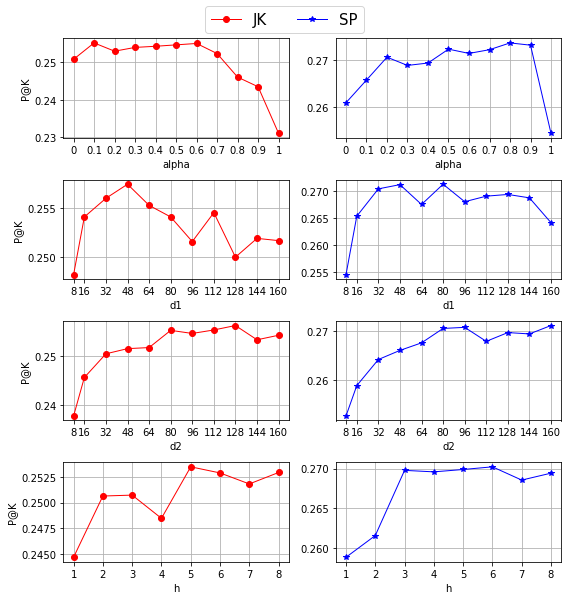

In [134]:
"""
绘制函数
"""
# 绘制曲线
line_color = ['red', 'blue', 'grey', 'chocolate', 'green', 'purple', 'pink', 'yellow', 'black', 'cyan', 'magenta']
lint_mark = [ 'o', '*', '<', '1', '2', '3', '4', ',', '^', '>', 'p']
# index_x = [i + 1 for i in range(len(K_list))]
city_list = ["JK", "SP"]
row_list = ['alpha', 'd1', 'd2', 'h']
col_list = ['P@K']
row = len(row_list)
col = len(col_list) * len(city_list)
fig, axes = plt.subplots(row, col,figsize=(8, 8))
for tmp_row in range(row):
    for tmp_col in range(len(col_list)):
        # tmp_city = col_list[tmp_col]
        # tmp_PRF1 = row_list[tmp_row]
        count = 0
        for city_num in range(len(city_list)):
            # 绘制曲线
            axes[tmp_row, tmp_col + city_num*len(col_list)].plot(X_list[tmp_row], Y_list[tmp_col][tmp_row][city_num],
                            color=line_color[count], linewidth=1.0, label=city_list[city_num],marker=lint_mark[count])
            axes[tmp_row, tmp_col + city_num*len(col_list)].set_xticks(X_list[tmp_row], [str(kk) for kk in X_list[tmp_row]])
            # 添加样式
            # if tmp_row == 0:
            #     axes[tmp_row, tmp_col + city_num*len(col_list)].set_title(city_list[city_num], fontdict={"fontsize": 18})  # 标题
            if tmp_col + city_num*len(col_list) == 0:
                axes[tmp_row, tmp_col + city_num*len(col_list)].set_ylabel('P@K', fontdict={"fontsize": 10})  # 添加纵轴标签
            axes[tmp_row, tmp_col + city_num*len(col_list)].set_xlabel(row_list[tmp_row])  # 添加横轴标签
            
            axes[tmp_row, tmp_col + city_num*len(col_list)].grid(True)
            count += 1
fig.legend(city_list, loc='upper center', ncol=len(city_list), bbox_to_anchor=(0.5, 1.05),
               fontsize=15)  # 绘制前len(methods)个图例
plt.tight_layout()
plt.savefig('result_pic/sensitivity_result.jpg', dpi=200, bbox_inches='tight')
plt.show()

# 修数据

In [159]:
alpha_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
d_1_list = [8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160]
d_2_list = [8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160]
head_list = [1, 2, 3, 4, 5, 6, 7, 8]
X_list = [alpha_list, d_1_list, d_2_list, head_list]

# 阿尔法敏感性实验:
P_K_alpha = [[0.19941894736842386, 0.20250105263158172, 0.20606421052631873, 0.20633894736842367, 0.20499789473684492, 0.20246421052631866, 0.2008284210526347, 0.19855157894737108, 0.19087578947368687, 0.18868631578947601, 0.18278736842105456], 
             [0.2596000000000035, 0.2664320000000037, 0.269120000000039, 0.26876800000000367, 0.26835200000000403, 0.2671280000000037, 0.26312800000000415, 0.25644800000000396, 0.25540000000000374, 0.25533600000000424, 0.2505040000000035]]
# R_liat: [[0.5831827508981181, 0.5940052270033532, 0.6032735627255637, 0.6007572549264946, 0.5976612214565703, 0.608183039650671, 0.6095183883456355, 0.5930100256577222, 0.5864859059312519, 0.5839570485591857, 0.5254614357503634], [0.5641496098068493, 0.5906323309364233, 0.6035458552428005, 0.6012790130410326, 0.5965383462700207, 0.6026281180052286, 0.6094695000104065, 0.6093850943563236, 0.582288121487026, 0.5893380136989714, 0.5458252680067177]]
# F1_liat: [[0.29720764575022146, 0.30203558265461034, 0.3055266602576246, 0.3060636767029844, 0.3048389746751895, 0.3088323769915693, 0.30784785836245937, 0.30196255501711367, 0.29925441766856214, 0.29649257702183346, 0.2712252335824108], [0.35557617418390386, 0.3672147234916327, 0.3720536936392532, 0.3705268291672291, 0.3701790034935087, 0.37284843102052684, 0.37721122094793336, 0.3765455645689162, 0.3646132808626918, 0.3659209847408712, 0.3434040515836489]]

# SHJ-walk的vec维度敏感性实验:
P_K_SHJ_WALK_D1 = [[0.20436000000000288,0.20536000000000288, 0.20612842105263446, 0.20688105263158184, 0.20721157894737132, 0.20716210526316073, 0.2071978947368451, 0.20723157894737135, 0.20701052631579234, 0.20721473684210803, 0.20709052631579236], 
                   [0.25936000000000288,0.26304000000000344, 0.26678400000000363, 0.26822400000000396, 0.27109200000000384, 0.27105200000000375, 0.2718320000000037, 0.2701280000000038, 0.2700080000000037, 0.271120000000004, 0.2712400000000038]]
# R_liat: [[0.6117635342545349, 0.6000455088239384, 0.6040248065616698, 0.6088510987564979, 0.6044258202005938, 0.6120284026312179, 0.6054523177130952, 0.6013746929398707, 0.6053321252111441, 0.5952880415149511], [0.5829858404382554, 0.5948380034639941, 0.6007584984514569, 0.6113884365939255, 0.6033680507087366, 0.5898225240360518, 0.5925215664071101, 0.5927168781911745, 0.5964217625750845, 0.5911171045107835]]
# F1_liat = [[0.3097338684430069, 0.30573718452853527, 0.3083124507066808, 0.30952766264175857, 0.3054486124342683, 0.3084691592956732, 0.3076649595231525, 0.30577959744658817, 0.30763044684627394, 0.30285615732550053], [0.362514787556966, 0.36835885585260236, 0.3708650706553519, 0.3764907710225664, 0.3739675816347633, 0.369329193403951, 0.36918983637488373, 0.36911326694491714, 0.3699352720541937, 0.36902227472725674]]

# GAT的vec维度敏感性实验:
P_GAT_D2 = [[0.18984421052631806, 0.1977094736842132, 0.20254736842105542, 0.20360000000000295, 0.20581894736842393, 0.20633473684210826, 0.20670736842105555, 0.20741473684210812, 0.20832421052631872, 0.2054105263157923, 0.2063368421052659],
            [0.25282800000000355, 0.25894800000000356, 0.2642040000000039, 0.2660400000000038, 0.26956000000000374, 0.27046400000000387, 0.2706840000000039, 0.2678640000000039, 0.26963200000000376, 0.26936000000000376, 0.271052000000004]]

# GAT 注意力头个数敏感性实验：
P_GAT_head = [[0.19672000000000242, 0.2026273684210554, 0.20271578947368676, 0.20047578947368677, 0.20544421052631842, 0.20485473684210836, 0.20379368421052907, 0.20489684210526588], 
              [0.25885200000000363, 0.26158000000000353, 0.26776800000000356, 0.2695800000000039, 0.26987600000000367, 0.27021200000000367, 0.26854800000000395, 0.26941600000000365]]


PK_ALL = [P_K_alpha, P_K_SHJ_WALK_D1, P_GAT_D2, P_GAT_head]
RK_ALL = [P_K_alpha, P_K_SHJ_WALK_D1, P_GAT_D2, P_GAT_head]
F1_ALL = [P_K_alpha, P_K_SHJ_WALK_D1, P_GAT_D2, P_GAT_head]

Y_list = [PK_ALL, RK_ALL, F1_ALL]

for i in range(len(P_K_alpha[0])):
    P_K_alpha[0][i] += 0.048
for i in range(len(P_K_SHJ_WALK_D1[0])):
    P_K_SHJ_WALK_D1[0][i] += 0.047
for i in range(len(P_GAT_D2[0])):
    P_GAT_D2[0][i] += 0.048
for i in range(len(P_GAT_head[0])):
    P_GAT_head[0][i] += 0.048

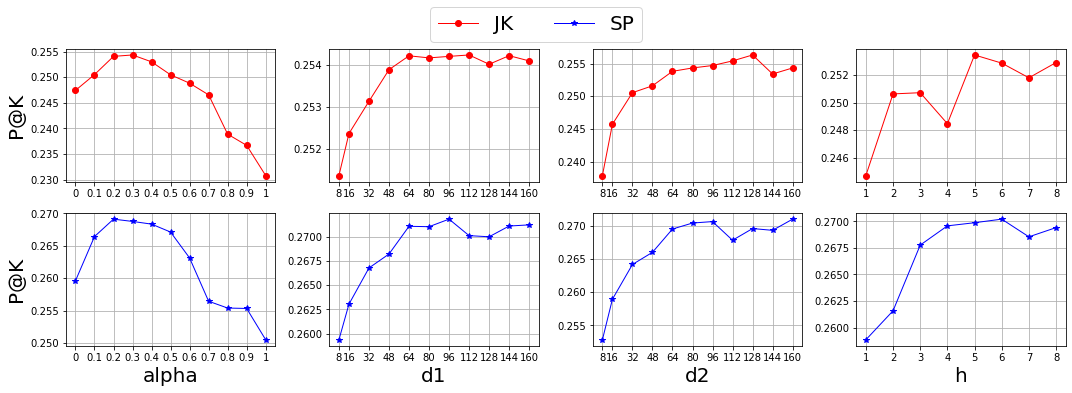

In [160]:
"""
绘制函数
"""
# 绘制曲线
line_color = ['red', 'blue', 'grey', 'chocolate', 'green', 'purple', 'pink', 'yellow', 'black', 'cyan', 'magenta']
lint_mark = [ 'o', '*', '<', '1', '2', '3', '4', ',', '^', '>', 'p']
# index_x = [i + 1 for i in range(len(K_list))]
row_list = ["JK", "SP"]
col_list = ['alpha', 'd1', 'd2', 'h']
row = len(row_list)
col = len(col_list)
fig, axes = plt.subplots(row, col, figsize=(15, 5))
flag = 0
for tmp_col in range(col):
    for tmp_row in range(row):  
        axes[tmp_row , tmp_col].plot(X_list[tmp_col], Y_list[0][tmp_col][tmp_row],
                        color=line_color[tmp_row], linewidth=1.0, label=city_list[tmp_row],marker=lint_mark[tmp_row])
        axes[tmp_row , tmp_col].set_xticks(X_list[tmp_col], [str(kk) for kk in X_list[tmp_col]])
        # 添加样式
        # if tmp_row == 0:
        #     axes[tmp_row, tmp_col + city_num*len(col_list)].set_title(city_list[city_num], fontdict={"fontsize": 18})  # 标题
        if tmp_col == 0:
            axes[tmp_row , tmp_col].set_ylabel('P@K', fontproperties='Times New Roman', size=20)  # 添加纵轴标签
        if tmp_row == 1:
            axes[tmp_row , tmp_col].set_xlabel(col_list[tmp_col], fontproperties='Times New Roman', size=20)  # 添加横轴标签
        axes[tmp_row , tmp_col].grid(True)
    if flag == 0:
        flag = 1
        fig.legend(city_list, loc='upper center', ncol=len(city_list), bbox_to_anchor=(0.5, 1.11),  fontsize=20)  # 绘制前len(methods)个图例 
    
#fig.legend()  # 绘制前len(methods)个图例
# fig.legend(city_list, loc='upper center', ncol=len(city_list), bbox_to_anchor=(0.5, 1.10),  fontsize=15)  # 绘制前len(methods)个图例
plt.tight_layout()
plt.savefig('result_pic/sensitivity_result.jpg', dpi=200, bbox_inches='tight')
plt.show()

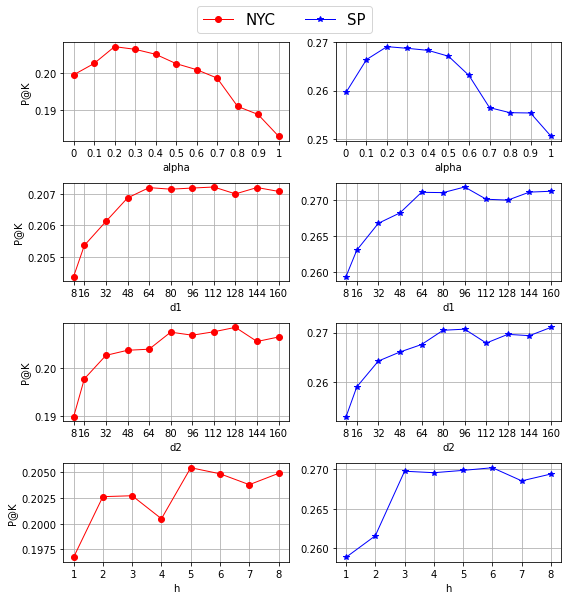

In [109]:
"""
绘制函数
"""
# 绘制曲线
line_color = ['red', 'blue', 'grey', 'chocolate', 'green', 'purple', 'pink', 'yellow', 'black', 'cyan', 'magenta']
lint_mark = [ 'o', '*', '<', '1', '2', '3', '4', ',', '^', '>', 'p']
# index_x = [i + 1 for i in range(len(K_list))]
city_list = ["JK", "SP"]
row_list = ['alpha', 'd1', 'd2', 'h']
col_list = ['P@K']
row = len(row_list)
col = len(col_list) * len(city_list)
fig, axes = plt.subplots(row, col,figsize=(8, 8))
for tmp_row in range(row):
    for tmp_col in range(len(col_list)):
        # tmp_city = col_list[tmp_col]
        # tmp_PRF1 = row_list[tmp_row]
        count = 0
        for city_num in range(len(city_list)):
            # 绘制曲线
            axes[tmp_row, tmp_col + city_num*len(col_list)].plot(X_list[tmp_row], Y_list[tmp_col][tmp_row][city_num],
                            color=line_color[count], linewidth=1.0, label=city_list[city_num],marker=lint_mark[count])
            axes[tmp_row, tmp_col + city_num*len(col_list)].set_xticks(X_list[tmp_row], [str(kk) for kk in X_list[tmp_row]])
            # 添加样式
            # if tmp_row == 0:
            #     axes[tmp_row, tmp_col + city_num*len(col_list)].set_title(city_list[city_num], fontdict={"fontsize": 18})  # 标题
            if tmp_col + city_num*len(col_list) == 0:
                axes[tmp_row, tmp_col + city_num*len(col_list)].set_ylabel('P@K', fontdict={"fontsize": 10})  # 添加纵轴标签
            axes[tmp_row, tmp_col + city_num*len(col_list)].set_xlabel(row_list[tmp_row])  # 添加横轴标签
            
            axes[tmp_row, tmp_col + city_num*len(col_list)].grid(True)
            count += 1
fig.legend(city_list, loc='upper center', ncol=len(city_list), bbox_to_anchor=(0.5, 1.05),
               fontsize=15)  # 绘制前len(methods)个图例
plt.tight_layout()
plt.savefig('result_pic/sensitivity_result.jpg', dpi=200, bbox_inches='tight')
plt.show()